In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import pandas as pd
# from tqdm.notebook import tqdm
from time import time
import math
from pytz import timezone
import argparse
import random
import sklearn
# import torch.fx
# from ipywidgets import IntProgress
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import tqdm
import copy
from datetime import datetime
from sklearn.metrics import classification_report
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim

from pytz import timezone
import datetime as dt

from torch.utils.data import DataLoader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Train Augmentation
train_transforms = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.Rotate(p=0.1, limit=(-15, 15)),  # 회전
        A.RandomBrightnessContrast(p=0.1, brightness_limit=(-0.1, 0.1), contrast_limit=0),  # 밝기 조절
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.1),  # 노이즈
        A.HorizontalFlip(p=0.3),  # 좌우 반전
        A.ShiftScaleRotate(p=0.2, shift_limit=0.05, scale_limit=0.05, rotate_limit=15),  # 이동/축소/회전
        A.GridDistortion(p=0.2),  # 그리드 왜곡
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), p=0.3),  # 랜덤 크롭
        A.MotionBlur(p=0.1),  # 블러
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # 정규화
        ToTensorV2(),
    ]
)


# Test Augmentation
test_transforms = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

'\nimport albumentations as A\nfrom albumentations.pytorch import ToTensorV2\n\ntrain_transforms = A.Compose(\n    [\n        A.Resize(height=256, width=256),\n        A.Rotate(p=0.1, limit=(-10, 10)),  # 랜덤 회전 적용\n        A.RandomBrightnessContrast(p=0.1, brightness_limit=(-0.1, 0.1), contrast_limit=0),  # 밝기만 조절\n        A.Normalize(mean=(0.44, 0.44, 0.44), std=(0.2447, 0.2447, 0.2447)),\n        ToTensorV2(),\n    ]\n)\n\ntest_transforms = A.Compose(\n    [\n        A.Resize(height=256, width=256),\n        A.Normalize(mean=(0.44, 0.44, 0.44), std=(0.2447, 0.2447, 0.2447)),\n        ToTensorV2(),\n    ]\n)\n'

In [ ]:
import os
import glob
import random
from itertools import chain  # flatten 대체

# 데이터 경로 설정
train_data_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Train'
valid_data_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Valid'
test_data_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test'

# 클래스 설정
classes = ['ILD', 'Lung_Cancer', 'Normal']

# Flatten 함수 대체
def flatten(l):
    return list(chain.from_iterable(l))

# Train 이미지 경로 수집
train_image_paths = []
for class_name in classes:
    class_path = os.path.join(train_data_path, class_name)
    train_image_paths += glob.glob(os.path.join(class_path, '*'))

random.shuffle(train_image_paths)

print(f"Train size: {len(train_image_paths)}")
print(f"Train image path example: {train_image_paths[0]}")
print(f"Classes: {classes}")

# Validation 이미지 경로 수집
valid_image_paths = []
for class_name in classes:
    class_path = os.path.join(valid_data_path, class_name)
    valid_image_paths += glob.glob(os.path.join(class_path, '*'))

print(f"Valid size: {len(valid_image_paths)}")

# Test 이미지 경로 수집
test_image_paths = []
for class_name in classes:
    class_path = os.path.join(test_data_path, class_name)
    test_image_paths += glob.glob(os.path.join(class_path, '*'))

print(f"Test size: {len(test_image_paths)}")

# 최종 결과 출력
print("Train size: {}\nValid size: {}\nTest size: {}".format(
    len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


Train size: 6300
Train image path example: /content/drive/MyDrive/Colab Notebooks/AI/Image/Train/Normal/ChestCT_Normal_00001868.png
Classes: ['ILD', 'Lung_Cancer', 'Normal']
Valid size: 700
Test size: 875
Train size: 6300
Valid size: 700
Test size: 875


In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'ILD': 0, 'Lung_Cancer': 1, 'Normal': 2}

In [ ]:
class DiseaseDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

#######################################################
#                  Create Dataset
#######################################################

train_dataset = DiseaseDataset(train_image_paths,train_transforms)
valid_dataset = DiseaseDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = DiseaseDataset(test_image_paths,test_transforms)

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[46][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[0][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 300, 300])
The label for 50th image in train dataset:  2


In [ ]:
#######################################################
#                  Define Dataloaders
#######################################################
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, drop_last=True,
)

valid_loader = DataLoader(
    valid_dataset, batch_size=16, shuffle=True, drop_last= True,
)


test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False,
)

In [ ]:
# loader = {'train':train_loader, 'val':valid_loader, 'test':test_loader}
loader = {'train':train_loader, 'val':valid_loader, 'test':test_loader}

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([16, 3, 300, 300])

In [ ]:
"""
from torchvision import models
from torchvision.models import vgg16  # VGG16 가져오기

model = vgg16(pretrained=False)  # VGG16 모델 선언
num_ftrs = model.classifier[-1].in_features  # 마지막 FC 레이어 입력 노드 수
model.classifier[-1] = torch.nn.Linear(num_ftrs, 3)  # 클래스 수에 맞게 수정
"""
import torch
from torchvision import models
# DenseNet121 불러오기 (pretrained 모델 사용)
model = models.densenet121(pretrained=True)

# 마지막 Fully Connected Layer 수정
num_classes = 3  # 예측 클래스 개수 (Normal, Lung Cancer, Pneumothorax, Pneumonia, ILD)
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

"""
from torchvision.models import efficientnet_b3  # EfficientNet-b0 사용 예시
# EfficientNet 불러오기
model = efficientnet_b3(pretrained=True)  # EfficientNet-b0 불러오기 (pretrained=True로 학습된 가중치 사용)
# 마지막 Fully Connected Layer 수정
num_ftrs = model.classifier[1].in_features  # EfficientNet-b0의 마지막 FC 레이어
model.classifier[1] = torch.nn.Linear(num_ftrs, 3)  # 클래스 수에 맞게 수정
"""

# Device 설정 (GPU 사용 시)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)  # 모델 구조 확인



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
#Early Stop
import time
import statistics
from torch.cuda.amp import GradScaler, autocast

# Early Stopping 파라미터
patience = 5  # 성능 개선이 없을 경우 기다리는 epoch 수
best_acc = 0.0
patience_counter = 0  # patience를 카운트할 변수

batch_size = 64
scaler = GradScaler()  # GradScaler 선언

# 모델 학습
for epoch in range(60):
    running_loss = 0.0
    total = 0
    correct = 0
    model.train()  # 모델을 훈련 모드로 설정

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # 그래디언트 초기화

        # Mixed Precision Training 적용
        with autocast():  # FP16 연산 활성화
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Scaler를 사용해 그래디언트 스케일링
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    # 훈련 정확도 출력
    accuracy = 100 * correct / total
    print(f'[{epoch + 1}/{20}] Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

    # 검증 데이터에서 정확도 계산
    total = 0
    correct = 0
    model.eval()  # 모델을 검증 모드로 설정
    for i, data in enumerate(valid_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f'[{epoch + 1}] Validation Accuracy: {val_acc:.2f}%')

    # Early Stopping 체크
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0  # 성능 개선되면 patience 카운터 리셋
        # 모델 저장
        save_path = '/content/drive/MyDrive/Colab Notebooks/AI/DenseNetver1'
        torch.save(model, f'{save_path}/LungCancer_{epoch}+{best_acc:.2f}.pth')
        print(f'Model saved with accuracy: {best_acc:.2f}%')
    else:
        patience_counter += 1  # 성능 개선되지 않음
        print(f'Patience counter: {patience_counter}/{patience}')

    if patience_counter >= patience:  # patience만큼 성능 개선이 없으면 종료
        print('Early stopping triggered.')
        break


<ipython-input-49-d929638d9107>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # GradScaler 선언
<ipython-input-49-d929638d9107>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # FP16 연산 활성화


[1/20] Loss: 0.1967, Accuracy: 93.53%
[1] Validation Accuracy: 99.27%
Model saved with accuracy: 99.27%
[2/20] Loss: 0.0362, Accuracy: 98.93%
[2] Validation Accuracy: 99.56%
Model saved with accuracy: 99.56%
[3/20] Loss: 0.0256, Accuracy: 99.24%
[3] Validation Accuracy: 99.56%
Patience counter: 1/5
[4/20] Loss: 0.0162, Accuracy: 99.51%
[4] Validation Accuracy: 99.71%
Model saved with accuracy: 99.71%
[5/20] Loss: 0.0148, Accuracy: 99.55%
[5] Validation Accuracy: 99.42%
Patience counter: 1/5
[6/20] Loss: 0.0083, Accuracy: 99.75%
[6] Validation Accuracy: 99.56%
Patience counter: 2/5
[7/20] Loss: 0.0069, Accuracy: 99.81%
[7] Validation Accuracy: 99.56%
Patience counter: 3/5
[8/20] Loss: 0.0100, Accuracy: 99.70%
[8] Validation Accuracy: 99.56%
Patience counter: 4/5
[9/20] Loss: 0.0048, Accuracy: 99.83%
[9] Validation Accuracy: 99.42%
Patience counter: 5/5
Early stopping triggered.


<ipython-input-53-0206e827d715>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/AI/Efiver3/LungCancer_3+99.71.pt


Classification Report:
              precision    recall  f1-score   support

         ILD       1.00      1.00      1.00       185
 Lung_Cancer       0.99      1.00      1.00       175
      Normal       1.00      1.00      1.00       515

    accuracy                           1.00       875
   macro avg       1.00      1.00      1.00       875
weighted avg       1.00      1.00      1.00       875

Accuracy for class: ILD       is 100.000 %
Accuracy for class: Lung_Cancer is 100.000 %
Accuracy for class: Normal    is 99.806 %
Accuracy for all classes: 99.94 %
Execution time : 23.419878721237183


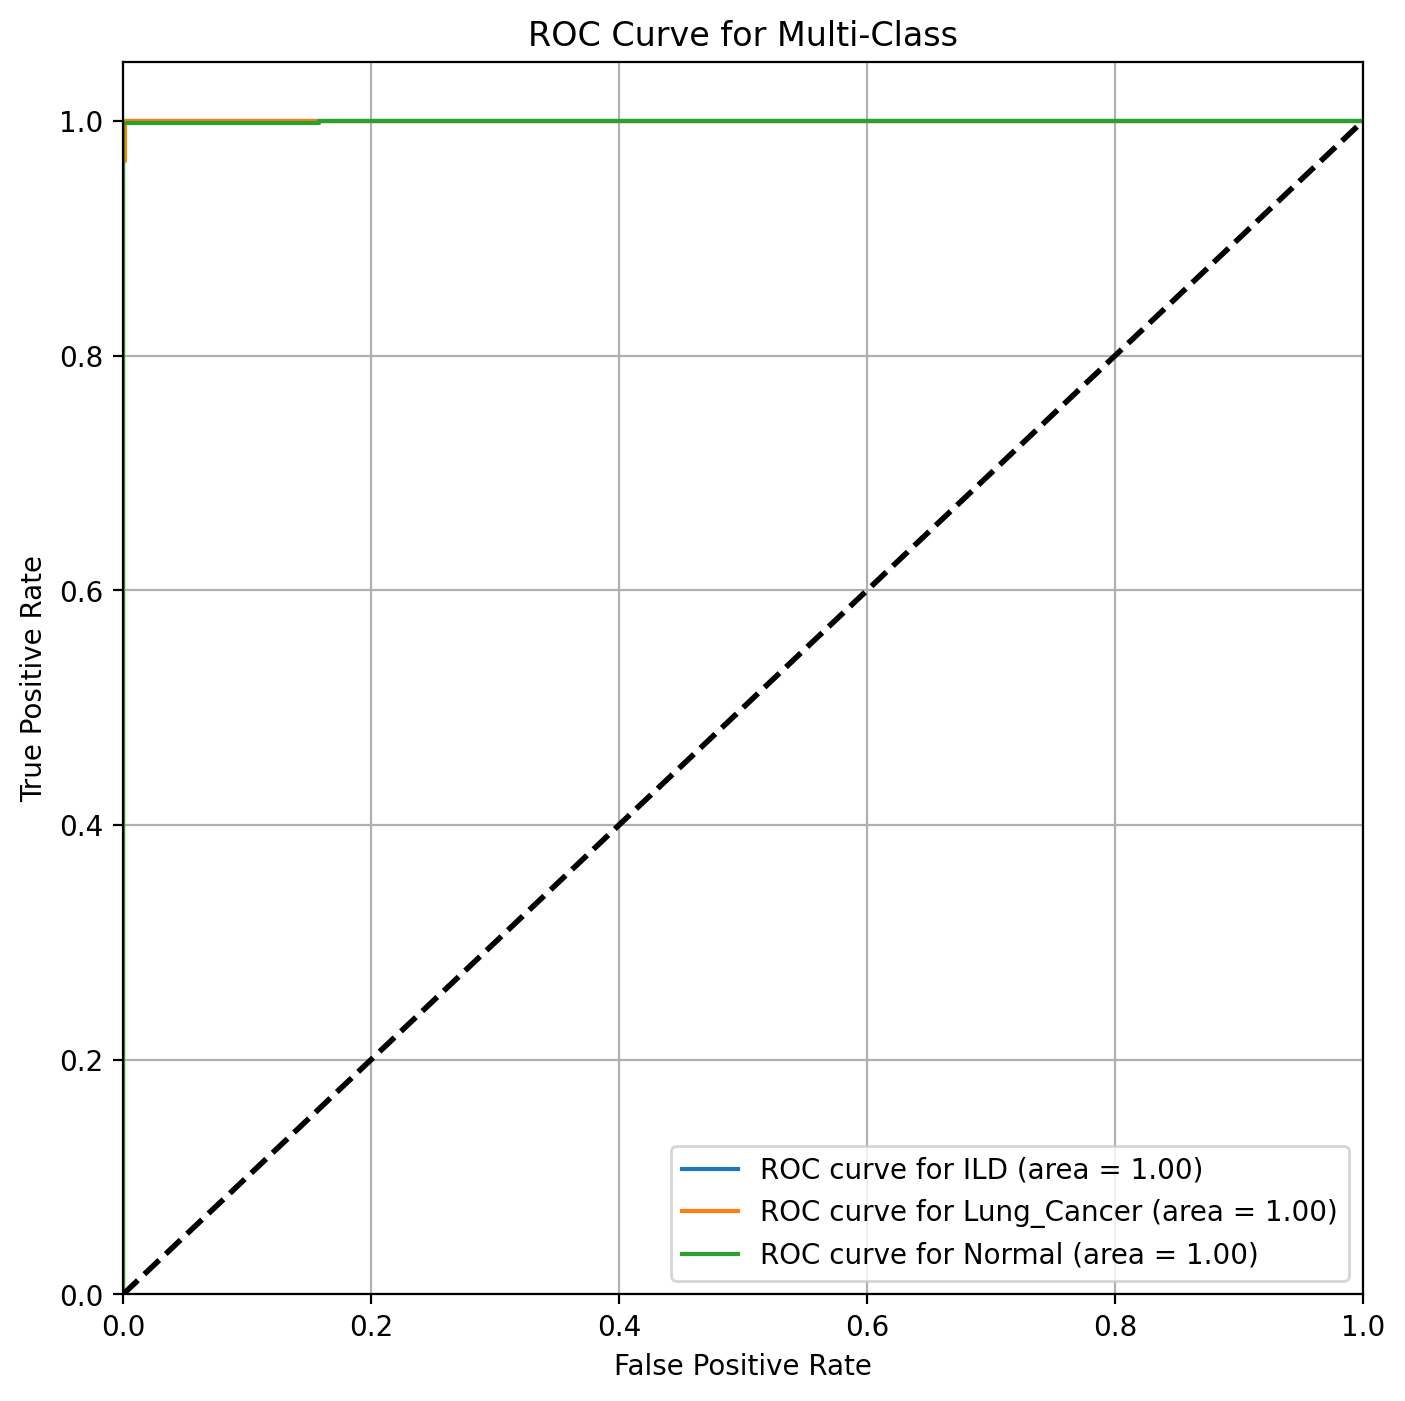

In [ ]:
import time
import statistics
import torch
from torchvision import models
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 클래스 3개 설정
classes = ['ILD', 'Lung_Cancer', 'Normal']

# 정답 및 예측 결과 초기화
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 저장된 가중치 로드
model = torch.load('/content/drive/MyDrive/Colab Notebooks/AI/Efiver3/LungCancer_3+99.71.pth', map_location='cuda')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y = []          # 실제 라벨
y_pred = []     # 예측 라벨
probas_y = []   # 예측 확률값 저장
start = time.time()

# Test 데이터에 대해 예측 수행
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # 모델 출력
        outputs = model(images)
        probas = torch.softmax(outputs, dim=1)  # 소프트맥스 적용 (확률값)
        probas_y.extend(probas.cpu().numpy())   # 확률값 저장

        _, predictions = torch.max(outputs, 1)  # 예측 클래스 가져오기

        # 정답 및 예측값 기록
        for label, prediction in zip(labels, predictions):
            y.append(int(label))           # 실제 라벨 저장
            y_pred.append(int(prediction)) # 예측 라벨 저장

            # 클래스별 정답 기록
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# F1 Score 및 기타 지표 출력
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=classes))

# 클래스별 정확도 출력
correct_list = []
for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:  # 해당 클래스에 샘플이 존재할 때만 계산
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:9s} is {accuracy:.3f} %')
        correct_list.append(accuracy)
    else:
        print(f'Accuracy for class: {classname:9s} is No samples in test set')

# 전체 평균 정확도 출력
if correct_list:
    correct_mean = statistics.mean(correct_list)
    print(f'Accuracy for all classes: {correct_mean:.2f} %')

print("Execution time :", time.time() - start)  # 실행 시간 출력

# ROC Curve 그리기 함수
def plt_roc(y_true, probas_y, classes):
    y_bin = label_binarize(y_true, classes=[0, 1, 2])  # 라벨 이진화 (다중 클래스 -> OvR)
    probas_y = np.array(probas_y)
    n_classes = len(classes)

    # ROC Curve 계산
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probas_y[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 전체 ROC Curve 시각화
    plt.figure(figsize=(8, 8))
    for i, class_name in enumerate(classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_name} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 무작위 예측 기준선
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# ROC Curve 그리기
plt_roc(y, probas_y, classes)


<ipython-input-74-8a23c60e6c6f>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/AI/Efiver3/LungCancer_3+99.71.pt

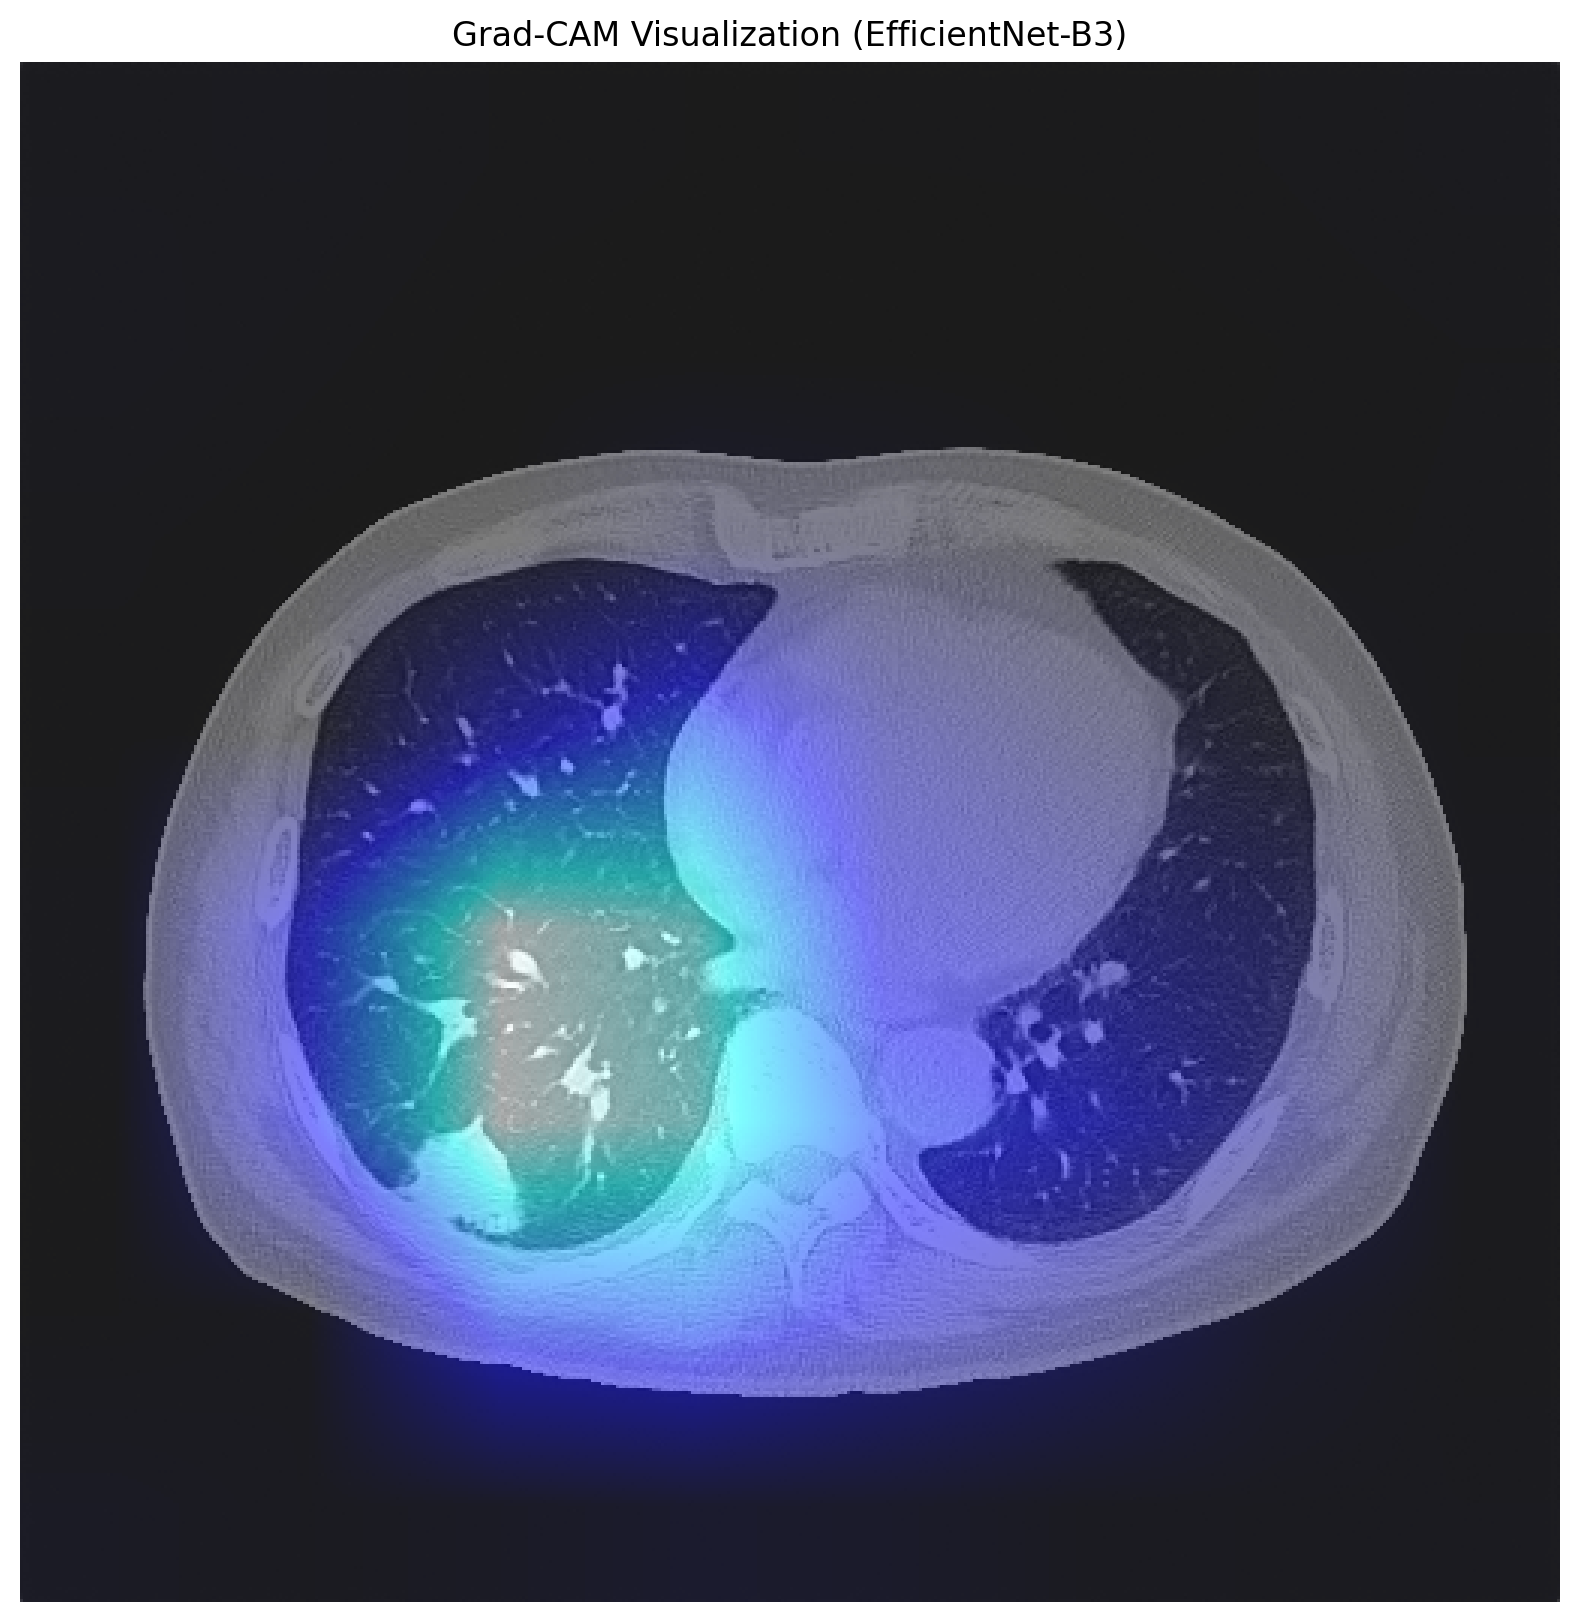

In [ ]:
# Grad-CAM for EfficientNet-B3
import torch
import numpy as np
import cv2
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Grad-CAM을 계산하는 함수
def get_grad_cam(model, input_tensor, target_layer, target_class, image_size):
    gradients = None
    activations = None

    # Hook 함수
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Hook 등록
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)

    # 모델 예측
    model.eval()
    output = model(input_tensor)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    # Grad-CAM 계산
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations[0]
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1.0

    # 이미지 크기에 맞게 리사이즈
    heatmap = cv2.resize(heatmap, image_size)
    return heatmap

# Grad-CAM 시각화 함수
def visualize_grad_cam_efficientnet(image_path, model, target_layer, target_class, transform):
    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    image_size = (image.size[0], image.size[1])

    # Grad-CAM 계산
    heatmap = get_grad_cam(model, input_tensor, target_layer, target_class, image_size)

    # Heatmap Overlay
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    img = np.array(image)
    superimposed_img = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0)

    # 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title('Grad-CAM Visualization (EfficientNet-B3)')
    plt.show()

# 모델 로드 및 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b3(pretrained=False)
num_classes = 3  # 클래스 개수 설정
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)

# 학습된 가중치 불러오기
model = torch.load('/content/drive/MyDrive/Colab Notebooks/AI/Efiver3/LungCancer_3+99.71.pth', map_location=device)

model.to(device)

# Grad-CAM 실행 설정
target_layer = model.features[-1]  # 마지막 Convolutional Layer
transform = transforms.Compose([
    transforms.Resize((244, 244)),  # EfficientNet-B3 입력 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# 이미지 경로 및 클래스 설정
image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/Lung_Cancer/ChestCT_Lung_Cancer_00001099.png'
#image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/Lung_Cancer/00031.png'
#image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/ILD/ChestCT_ILD_00001098.png'
#image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/ILD/5507986.jpg'
target_class = 1  # 예시: Lung_Cancer 클래스

# Grad-CAM 실행
visualize_grad_cam_efficientnet(image_path, model, target_layer, target_class, transform)


<ipython-input-10-d5fdc8f91833>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/AI/VGGver2/LungCancer_6+99.13.pt

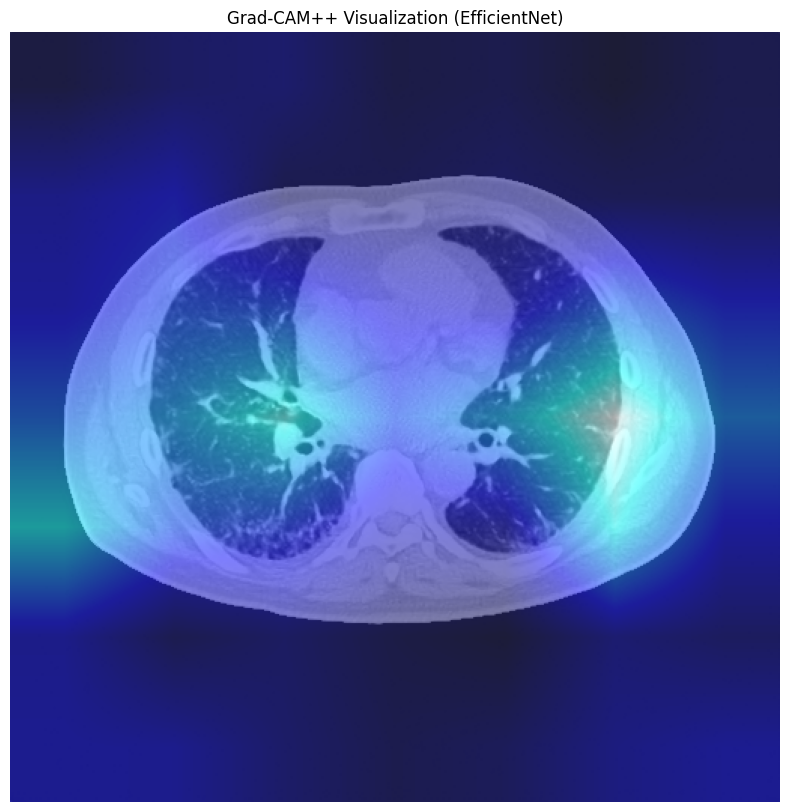

In [ ]:
#VGG Grad_CAM
import torch
import numpy as np
import cv2
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

def get_grad_cam_plus_plus(model, input_tensor, target_layer, target_class, image_size):
    """
    Grad-CAM++ 계산을 수행하는 함수.
    """
    # Gradients와 활성화 값 초기화
    gradients = None
    activations = None

    # Hook 함수 정의
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]  # Backward에서의 gradient 저장

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output  # Forward에서의 활성화 값 저장

    # Hook 등록
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)  # backward_hook 대신 사용

    # 모델 예측
    model.eval()
    output = model(input_tensor)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    # Grad-CAM++ 결과 생성
    gradients = gradients.cpu().detach()
    activations = activations.cpu().detach()

    alpha_num = gradients.pow(2)
    alpha_denom = gradients.pow(2) * 2 + (activations * gradients.pow(3)).sum(dim=[2, 3], keepdim=True)
    alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.tensor(1.0))  # Zero-division 방지
    alphas = alpha_num / alpha_denom
    weights = (alphas * torch.relu(gradients)).sum(dim=[2, 3])

    heatmap = torch.relu((weights[:, :, None, None] * activations).sum(dim=1)).squeeze()
    heatmap = heatmap / torch.max(heatmap) if torch.max(heatmap) != 0 else heatmap

    # 입력 이미지 크기로 리사이즈
    heatmap = cv2.resize(heatmap.numpy(), image_size)
    return heatmap

def visualize_grad_cam_plus_plus(image_path, model, target_layer, target_class, transform):
    """
    Grad-CAM++을 EfficientNet에 적용하여 시각화하는 함수.
    """
    # 이미지 로드
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    image_size = (image.size[0], image.size[1])

    # Grad-CAM++ 계산
    heatmap = get_grad_cam_plus_plus(model, input_tensor, target_layer, target_class, image_size)

    # Heatmap 원본 이미지에 Overlay
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)

    img = np.array(image)
    superimposed_img = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0)

    # 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title('Grad-CAM++ Visualization (EfficientNet)')
    plt.show()

# 모델 로드 및 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
model = models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, num_classes)

# 학습된 모델 가중치 로드
model = torch.load('/content/drive/MyDrive/Colab Notebooks/AI/DenseNetver1/LungCancer_10+100.00.pth', map_location=device)
model.to(device)

# Grad-CAM++ 실행
target_layer = model.features[-1]  # 마지막 컨볼루션 레이어
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet 기본 입력 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# 이미지 경로와 타겟 클래스 지정
#image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/Lung_Cancer/ChestCT_Lung_Cancer_00001099.png'
#image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/Lung_Cancer/00031.png'
image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/ILD/ChestCT_ILD_00001038.png'
#image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/ILD/5507986.jpg'
target_class = 0  # 예시: Lung Cancer 클래스

visualize_grad_cam_plus_plus(image_path, model, target_layer, target_class, transform)


In [ ]:
# Grad-CAM++ for DenseNet121
import torch
import numpy as np
import cv2
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Grad-CAM++ 계산 함수
def get_grad_cam_plus_plus(model, input_tensor, target_layer, target_class, image_size):
    """
    Grad-CAM++ 계산 함수.
    """
    gradients = None
    activations = None

    # Hook 함수 정의
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].clone()  # Gradient 저장 (clone 추가)

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output.clone()  # 활성화 값 저장 (clone 추가)

    # Hook 등록
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)

    # 모델 예측
    model.eval()
    output = model(input_tensor)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    # Grad-CAM++ 계산
    gradients = gradients.cpu().detach()
    activations = activations.cpu().detach()

    alpha_num = gradients.pow(2)
    alpha_denom = gradients.pow(2) * 2 + (activations * gradients.pow(3)).sum(dim=[2, 3], keepdim=True)
    alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.tensor(1.0))  # Zero-division 방지
    alphas = alpha_num / alpha_denom
    weights = (alphas * torch.relu(gradients)).sum(dim=[2, 3])

    heatmap = torch.relu((weights[:, :, None, None] * activations).sum(dim=1)).squeeze()
    heatmap = heatmap / torch.max(heatmap) if torch.max(heatmap) != 0 else heatmap

    # 이미지 크기로 리사이즈
    heatmap = cv2.resize(heatmap.numpy(), image_size)
    return heatmap

# Grad-CAM++ 시각화 함수
def visualize_grad_cam_plus_plus(image_path, model, target_layer, target_class, transform):
    """
    Grad-CAM++을 DenseNet121에 적용하고 시각화하는 함수.
    """
    # 이미지 전처리
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    image_size = (image.size[0], image.size[1])

    # Grad-CAM++ 계산
    heatmap = get_grad_cam_plus_plus(model, input_tensor, target_layer, target_class, image_size)

    # Heatmap을 원본 이미지에 Overlay
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    img = np.array(image)
    superimposed_img = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0)

    # 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title('Grad-CAM++ Visualization (DenseNet121)')
    plt.show()

# 모델 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=False)  # DenseNet121 모델
num_classes = 3
num_ftrs = model.classifier.in_features  # 마지막 FC 레이어 입력 특성 수
model.classifier = torch.nn.Linear(num_ftrs, num_classes)  # 클래스 개수에 맞게 수정

# 학습된 모델 불러오기
model = torch.load('/content/drive/MyDrive/Colab Notebooks/AI/DenseNetver1/LungCancer_10+100.00.pth', map_location=device)
model.to(device)

# Grad-CAM++ 실행 설정
target_layer = model.features[-1]  # DenseNet121의 마지막 컨볼루션 레이어
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 입력 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.44, 0.44, 0.44), std=(0.2447, 0.2447, 0.2447))
])

# 이미지 경로와 타겟 클래스 설정
#image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/Lung_Cancer/ChestCT_Lung_Cancer_00001099.png'
#image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/Lung_Cancer/00031.png'
image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/ILD/ChestCT_ILD_00001038.png'
#image_path = '/content/drive/MyDrive/Colab Notebooks/AI/Image/Test/ILD/5507986.jpg'
target_class = 0  # 예시: ILD 클래스

# Grad-CAM++ 실행
visualize_grad_cam_plus_plus(image_path, model, target_layer, target_class, transform)



<ipython-input-23-a0a609361dc9>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/AI/DenseNetver1/Lu

TypeError: Expected state_dict to be dict-like, got <class 'torchvision.models.densenet.DenseNet'>.

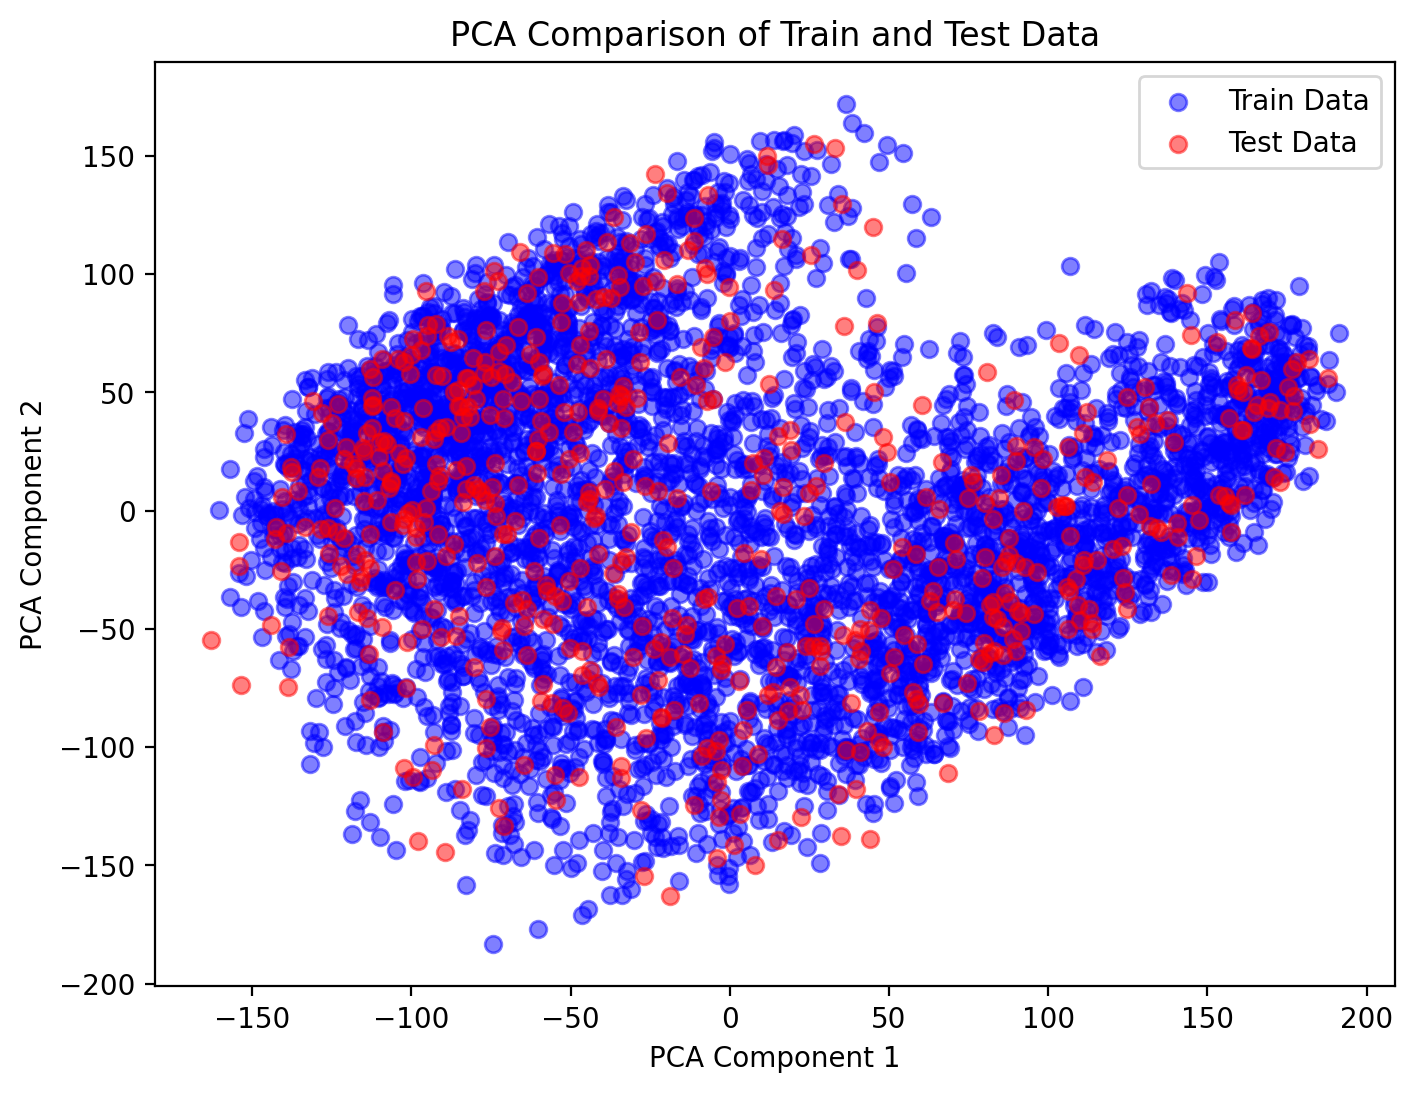

In [ ]:
#외부 데이터 분포 비교
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 데이터 준비 함수
def extract_features_and_labels(data_loader, model, device):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, target = data
            images = images.to(device)

            # 모델의 feature extraction
            outputs = model.features(images)  # DenseNet 기준
            outputs = torch.flatten(outputs, 1)  # Flatten 처리
            features.append(outputs.cpu().numpy())
            labels.extend(target.cpu().numpy())
    return np.vstack(features), np.array(labels)

# Train 데이터 및 Test 데이터 특징 추출
train_features, train_labels = extract_features_and_labels(train_loader, model, device)
test_features, test_labels = extract_features_and_labels(test_loader, model, device)

# 두 데이터를 결합 및 라벨링
X = np.vstack([train_features, test_features])
y = np.hstack([np.zeros(len(train_features)), np.ones(len(test_features))])  # 0: train, 1: test

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA로 2차원으로 변환
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', alpha=0.5, label='Train Data')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='red', alpha=0.5, label='Test Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Comparison of Train and Test Data')
plt.legend()
plt.show()
